# Basic (Gaussian likelihood) GP Regression model


The aim of this notebook is to show the different steps for creating and using a standard GP regression model:
  - reading and formatting data
  - choosing a kernel function
  - choosing a mean function
  - creating the model
  - viewing, getting and setting model parameters
  - optimising the model parameters
  - making predictions
  
We focus here on the implementation of the models in GPflow, and refer the reader to [A Practical Guide to Gaussian Processes](https://drafts.distill.pub/gp/) for getting more intuition on these models.
 

In [1]:
import gpflow
import numpy as np
import matplotlib

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

We denote by X and Y the input and output values. Note that `X` and `Y` must be two-dimensional numpy arrays, $N \times 1$ or $N \times D$, where $D$ is the number of input dimensions/features, with the same number of rows $N$ (one per data-point):

In [2]:
from wishart_likelihood import Wishart


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
df = 10
chi2 = gpflow.likelihoods.Gamma()
chi2.shape = df / 2
chi2.shape.trainable = False
chi2

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


,class,prior,transform,trainable,shape,fixed_shape,value
Gamma/shape,Parameter,None,+ve,False,(),True,5.0


In [4]:
ws = Wishart(df, 1)

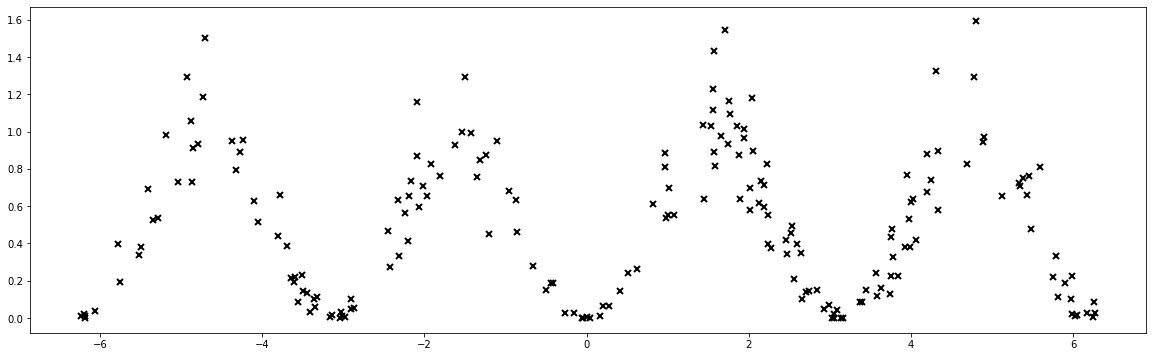

In [5]:
# data = np.genfromtxt('data/regression_1D.csv', delimiter=',')
# X = data[:, 0].reshape(-1, 1)
# Y = data[:, 1].reshape(-1, 1)
N = 200
X = np.random.uniform(-2 * np.pi, 2 * np.pi, (N, 1))
Y = (np.sin(X) + 0.1 * np.random.randn(N, 1)) ** 2

plt.figure(figsize=(20, 6))
plt.plot(X, Y, 'kx', mew=2)

We will consider the following probabilistic model:
$$ Y_i = f(X_i) + \varepsilon_i , $$
where $f \sim \mathcal{GP}(\mu(.), k(., .'))$, and $\varepsilon \sim \mathcal{N}(0, \tau^2 I)$.

Kernel 
--

Several kernels (i.e. covariance functions) are implemented in GPflow, and they can easily be combined to create new ones (see [advanced kernel notebook](../advanced/kernels.ipynb)). Implementing new covariance functions is also possible, as illustrated in the [kernel design notebook](../tailor/kernel_design.ipynb). Here, we will use a simple one:

In [6]:
# k = gpflow.kernels.Matern52(input_dim=1)
k = gpflow.kernels.SquaredExponential(1)

The `input_dim` parameter is the dimension of the input space. It typically corresponds to the number of columns in `X`  (see the [advanced kernel notebook](../advanced/kernels.ipynb) for kernels defined on subspaces). A summary of the kernel can be obtained, either by `print(k)` (plain text) or

In [7]:
k.as_pandas_table()  #, or simply:
k

,class,prior,transform,trainable,shape,fixed_shape,value
SquaredExponential/lengthscales,Parameter,None,+ve,True,(),True,1.0
SquaredExponential/variance,Parameter,None,+ve,True,(),True,1.0


The Matern 5/2 kernel has two parameters: `lengthscales` encoding the "wiggliness" of the GP, and `variance` which tunes the amplitude. They are both set to 1.0 as the default value.  More details on the meaning of the other columns can be found in the [advanced kernel notebook](../advanced/kernels.ipynb).

Mean function (optional)
--
It is common to choose $\mu = 0$, which is the GPflow default. 

If there is a clear pattern (such as a mean value of `Y` that is far away from 0, or a linear trend in the data), mean functions can however be beneficial. Some simple ones are provided in the `gpflow.mean_functions` module. Here's how to define a linear mean function: ` meanf = gpflow.mean_functions.Linear()`.

Model construction
--

A GPflow model is created by instantiating one of the GPflow model classes, in this case GPR. We'll make a kernel `k` and instantiate a GPR object using the generated data and the kernel. We'll set the variance of the likelihood to a sensible initial guess, too. 

In [8]:
m = gpflow.models.VGP(X, Y, kern=k, likelihood=ws, num_latent=1)

> /home/skitimoon/Python/GPflow/wishart_likelihood.py(26)logp()
-> W = construct_wishart(F, self.df, self.D)
(Pdb) self.df
10
(Pdb) self.D
1
(Pdb) Y.shape
TensorShape([Dimension(None), Dimension(None)])
(Pdb) F.shape
TensorShape([Dimension(None), Dimension(None)])
(Pdb) n
> /home/skitimoon/Python/GPflow/wishart_likelihood.py(27)logp()
-> scale = W / self.df
(Pdb) w.shape
  /home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/runpy.py(193)_run_module_as_main()
-> "__main__", mod_spec)
  /home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/runpy.py(85)_run_code()
-> exec(code, run_globals)
  /home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py(16)<module>()
-> app.launch_new_instance()
  /home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/traitlets/config/application.py(658)launch_instance()
-> app.start()
  /home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel/kernelapp.py(505)start()
-> self.io_loop.start()
  /ho

A summary of the model can be obtained, either by `print(m)` (plain text) or 

In [9]:
m.as_pandas_table()  #, or simply:
m

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
VGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
VGP/q_mu,Parameter,None,(none),True,"(200, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 200, 200)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


The first two lines correspond to the kernel parameters, and the third one gives the likelihood parameter (the noise variance $\tau^2$ in our model).

Those values can be accessed and set manually to sensible initial guesses, for instance:


In [ ]:
# m.likelihood.variance = 0.01
# m.kern.lengthscales = 0.3
# m.kern.variance = 0.01

Optimisation of the model parameters
--

In order to obtain meaningful predictions, we need to tune the model parameters (i.e. parameters of the kernel, likelihood and mean function if applicable) to the data at hand. 

There are several optimisers available in GPflow. Here we use the ScipyOptimizer which implements by default the L-BFGS-B algorithm (others can be selected using the `method=` keyword argument to `ScipyOptimizer`, for options see [the Scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)).

In [10]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)
m.as_pandas_table()

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


InvalidArgumentError: Input to reshape is a tensor with 20000 values, but the requested shape has 2000
	 [[node VGP-2d7ea805-8/Wishart/log_prob/Reshape_1 (defined at /home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tensorflow_probability/python/distributions/wishart.py:311) ]]

Caused by op 'VGP-2d7ea805-8/Wishart/log_prob/Reshape_1', defined at:
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-4e8676e2960e>", line 1, in <module>
    m = gpflow.models.VGP(X, Y, kern=k, likelihood=ws, num_latent=1)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/gpflow/core/compilable.py", line 90, in __init__
    self.build()
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/gpflow/models/model.py", line 79, in _build
    likelihood = self._build_likelihood()
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/gpflow/decors.py", line 67, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/gpflow/models/vgp.py", line 122, in _build_likelihood
    var_exp = self.likelihood.variational_expectations(fmean, fvar, self.Y)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/gpflow/likelihoods.py", line 668, in variational_expectations
    return self._mc_quadrature(self.logp, Fmu, Fvar, Y=Y, epsilon=epsilon)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/gpflow/likelihoods.py", line 599, in _mc_quadrature
    return ndiag_mc(funcs, self.num_monte_carlo_points, Fmu, Fvar, logspace, epsilon, **Ys)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/gpflow/quadrature.py", line 244, in ndiag_mc
    return eval_func(funcs)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/gpflow/quadrature.py", line 233, in eval_func
    feval = func(mc_Xr, **Ys)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/gpflow/decors.py", line 67, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "/home/skitimoon/Python/GPflow/wishart_likelihood.py", line 30, in logp
    W = Ytril + tf.matrix_transpose(Ytril) - tf.matrix_band_part(
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tensorflow_probability/python/distributions/distribution.py", line 714, in log_prob
    return self._call_log_prob(value, name)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tensorflow_probability/python/distributions/distribution.py", line 697, in _call_log_prob
    return self._log_prob(value, **kwargs)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tensorflow_probability/python/distributions/wishart.py", line 311, in _log_prob
    scale_sqrt_inv_x_sqrt = tf.reshape(scale_sqrt_inv_x_sqrt, shape)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 7179, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 20000 values, but the requested shape has 2000
	 [[node VGP-2d7ea805-8/Wishart/log_prob/Reshape_1 (defined at /home/skitimoon/miniconda3/envs/gpflow/lib/python3.6/site-packages/tensorflow_probability/python/distributions/wishart.py:311) ]]


Notice how the value column has changed.

The local optimum found by Maximum Likelihood may not be the one you want, e.g. it may be overfitting or be oversmooth. This depends on the initial values of hyperparameters and is specific to each data set. As an alternative to Maximum Likelihood, MCMC is also available as shown in the [MCMC notebook](../advanced/mcmc.ipynb).

### Prediction

We can now use the model to make some predictions at new locations `Xnew`. One may be interested in predicting two different quantities: the latent function values `f(Xnew)` (the denoised signal), or the values of new observations `y(Xnew)` (signal + noise). Since we are dealing with Gaussian probabilistic models, the predictions typically output a mean and variance. Alternatively, one can obtain samples of `f(Xnew)` or log-density of new data points `(Xnew, Ynew)`.

GPflow models have several prediction methods:

 - `m.predict_f` returns the mean and variance of $f$ at the points `Xnew`. 

 - `m.predict_f_full_cov` additionally returns the full covariance matrix of $f$ at the points `Xnew`.

 - `m.predict_f_samples` returns samples of the latent function.

 - `m.predict_y` returns the mean and variance of a new data point (i.e. includes the noise variance).

 - `m.predict_density` returns the log-density of the observations `Ynew` at `Xnew`.
 
We use `predict_f` and `predict_f_samples` to plot 95% confidence intervals and samples from the posterior distribution. 

In [ ]:
## generate test points for prediction
xx = np.linspace(-2 * np.pi, 2 * np.pi, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_y(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 100)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(16, 6))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx,  m.likelihood.shape.value * np.exp(samples[:, :, 0].T), 'C0', linewidth=.5, alpha=0.2);
# plt.xlim(-0.1, 1.1);


In [ ]:
m.kern

In [ ]:
m.likelihood

GP regression in higher dimension
--

Very little changes when the input space has more than one dimension. `X` is a numpy array with one column per dimension. The kernel may be set with `input_dim` equal to the number of columns of `X`, and setting the parameter `ARD=True` allows tuning a different lengthscale per dimension, which is generally recommended.

Further reading
--

Several notebooks are available to go into more details:

  - [Sparse GP regression for big data](../advanced/gps_for_big_data.ipynb) when there is a large number of observations,
  - [ordinal regression](../advanced/ordinal_regression.ipynb) if the data is ordinal,
  - [multi-outputs and coregionalisation](../advanced/coregionalisation.ipynb) if `Y` is multidimensional.